In [1]:
# Makes it easier to debug
%load_ext autoreload
#%load_ext line_profiler
%autoreload 2

In [108]:
import pylab as plt
import numpy as np
import torch
import torch.nn as nn
import typing as tp
from torch.nn import functional as F

import swyft
from swyft.lightning.components import (
    RatioEstimatorGaussian1d, MeanStd, SimpleDataset, subsample_posterior,
    get_1d_rect_bounds, append_randomized, valmap, SwyftModel, persist_to_file, 
    equalize_tensors, SwyftTrainer, SampleStore, dictstoremap, DictDataset, SwyftModule, SwyftDataModule, RatioSamples,
    RatioSampleStore, RatioEstimatorMLP1d
)


100%|██████████| 1/1 [00:00<00:00, 666.61it/s]

100%|██████████| 1/1 [00:00<00:00, 1048.31it/s]

tensor([-0.9820,  0.8036,  0.4418])


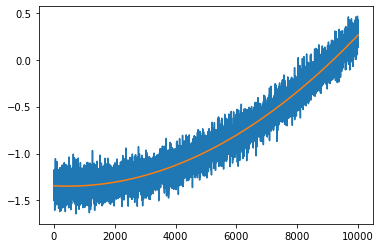

In [208]:
class Model(SwyftModel):
    def fast(self, S):
        d = S['mu'] + torch.randn_like(S['mu'])*0.1
        return SampleStore(data = d)
        
    def slow(self, S):
        a, b, c = S['z']
        x = np.linspace(-1, 1, 10000)
        mu = a+b*x + c*x**2
        return SampleStore(mu=mu.float())

    def prior(self, N, bounds = None):
        low = -np.ones(3)
        high = np.ones(3)
        if bounds is not None:
            low, high = bounds['z'].low, bounds['z'].high
        draw = np.array([np.random.uniform(low=low, high=high) for _ in range(N)])
        return SampleStore(z = torch.tensor(draw).float())
    
m = Model()
s0 = m.sample(1)[0]
plt.plot(s0['data'])
plt.plot(s0['mu'])
print(s0['z'])
b = None

In [244]:
class InferenceNet(SwyftModule):
    def __init__(self):
        super().__init__()
        #self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(dict(img = (50, 50)))
        self.CNN = torch.nn.Sequential(
            torch.nn.Conv1d(1, 5, 10),
            torch.nn.MaxPool1d(4),
            torch.nn.Conv1d(5, 15, 10),
            torch.nn.MaxPool1d(4),
            torch.nn.Flatten(),
            torch.nn.LazyLinear(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 16),
        )
        self.classifier = RatioEstimatorMLP1d(16, 3, hidden_features = 256)

    def forward(self, x, z):
        # Digesting x
        data = x['data']
        #x = self.online_z_score(x)['img']
        x = self.CNN(data.unsqueeze(1)).squeeze(1)
        
        out = self.classifier(x, z['z'])
        return dict(z = out)

## Workflow

In [245]:
m = Model()
s = m.sample(1000, bounds = b)


100%|██████████| 1000/1000 [00:00<00:00, 3607.10it/s][A

100%|██████████| 1000/1000 [00:00<00:00, 11124.24it/s]


In [246]:
# Access of individual samples
s[0]

{'data': tensor([-1.4379, -1.6781, -1.5185,  ...,  0.0115,  0.1354,  0.2451]),
 'z': tensor([-0.7551,  0.8551, -0.0078]),
 'mu': tensor([-1.6180, -1.6178, -1.6176,  ...,  0.0919,  0.0921,  0.0923])}

In [247]:
# Access of all samples with specific key
s['z']

tensor([[-0.7551,  0.8551, -0.0078],
        [-0.8595,  0.4026, -0.1552],
        [-0.6177,  0.8835, -0.0712],
        ...,
        [-0.9150,  0.5337,  0.1761],
        [-0.9008,  0.8445,  0.0487],
        [-0.6385,  0.5998,  0.1733]])

In [248]:
r = InferenceNet()
d = SwyftDataModule(s, model = m, batch_size = 64)

In [249]:
t = SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 20)
t.fit(r, d)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                | Params
---------------------------------------------------
0 | CNN        | Sequential          | 2.9 K 
1 | classifier | RatioEstimatorMLP1d | 810 K 
---------------------------------------------------
813 K     Trainable params
0         Non-trainable params
813 K     Total params
3.253     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [250]:
t.test(r, d)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'hp/JS-div': 0.8884434700012207, 'hp/KL-div': -6.920271873474121}
--------------------------------------------------------------------------------


[{'hp/JS-div': 0.8884434700012207, 'hp/KL-div': -6.920271873474121}]

In [251]:
p = t.infer(r, d, condition_x = s0)   # Weighted posterior samples
p

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 13it [00:00, ?it/s]

{'z': RatioSamples(values=tensor([[-0.7551,  0.8551, -0.0078],
         [-0.8595,  0.4026, -0.1552],
         [-0.6177,  0.8835, -0.0712],
         ...,
         [-0.9150,  0.5337,  0.1761],
         [-0.9008,  0.8445,  0.0487],
         [-0.6385,  0.5998,  0.1733]]), ratios=tensor([[-18.2002, -10.0811, -17.4092],
         [-14.0341, -14.8321, -22.6304],
         [-23.9311, -12.4020, -19.5780],
         ...,
         [-12.3773, -12.4555, -13.8478],
         [-12.9048,  -8.2066, -15.9622],
         [-23.1455, -12.2145, -13.8850]]), metadata={})}

In [252]:
ps = p.sample(10000)
ps

{'z': tensor([[-0.9885,  0.7938,  0.4578],
         [-0.9947,  0.7980,  0.4392],
         [-0.9873,  0.7980,  0.4607],
         ...,
         [-0.9897,  0.7980,  0.4573],
         [-0.9935,  0.7961,  0.4446],
         [-0.9932,  0.7839,  0.4679]])}

In [253]:
b = get_1d_rect_bounds(p, th = 1e-7)
b

{'z': RectangleBound(low=tensor([-0.9987,  0.4470,  0.2714]), high=tensor([-0.9078,  0.9179,  0.6050]))}

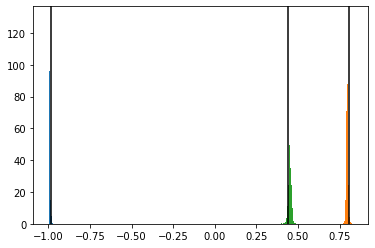

In [254]:
z = ps['z']
z0 = s0['z']
plt.hist(z[:,0].numpy(), bins = 20, density=True);
plt.hist(z[:,1].numpy(), bins = 20, density = True);
plt.hist(z[:,2].numpy(), bins = 20, density = True);
plt.axvline(z0[0], color='k')
plt.axvline(z0[1], color='k')
plt.axvline(z0[2], color='k')
#plt.xlim(-1, 1)